In [539]:
#loading data and concatenate them
import numpy as np

a = np.load("01_normal_Nov10_labeled.numpy")
b = np.load("03_with_memory_fill_Nov11_part1_labeled.numpy")
c = np.load("03_with_memory_fill_Nov11_part2_labeled.numpy")
d = np.load("03_with_memory_fill_Nov11_part3_labeled.numpy")
e = np.load("03_with_memory_fill_Nov11_part4_labeled.numpy")
f = np.load("05_with_network_partition_part1_labeled.numpy")
n = np.load("05_with_network_partition_part2_labeled.numpy")

all_data = np.concatenate((b,c,d,e,f,n))
print ("all data shape:",all_data.shape)

all data shape: (726, 244)


In [540]:
#handling features and labels
from sklearn import preprocessing

features = all_data[:,0:243]
features_scaled = preprocessing.scale(features)

labels = all_data[:,243].astype(int).reshape(-1)
one_hot_labels = np.eye(3)[labels]

print("the number of 0:",np.sum(labels==0))
print("the number of 1:",np.sum(labels==1))
print("the number of 2:",np.sum(labels==2))


the number of 0: 336
the number of 1: 129
the number of 2: 261


/anaconda/envs/tflearn/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [541]:
#split and shuffle data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
features_scaled_random,one_hot_labels_random = shuffle(features_scaled,one_hot_labels)
X_train, X_validation, y_train, y_validation = train_test_split(
    features_scaled_random, one_hot_labels_random, test_size=0.20, random_state=42)
print("the number of validation set:",X_train.shape[0])
print("the number of train set:",X_validation.shape[0])

the number of validation set: 580
the number of train set: 146


In [542]:
#model
import tensorflow as tf

input_data = tf.placeholder(tf.float32, shape=[None,243])
target_data = tf.placeholder(tf.float32, shape=[None,3])

hidden_nodes = 15

input_weights = tf.Variable(tf.truncated_normal([243,hidden_nodes]))
input_biases = tf.Variable(tf.zeros([hidden_nodes]))

hidden_weights = tf.Variable(tf.truncated_normal([hidden_nodes,3]))
hidden_biases = tf.Variable(tf.zeros([3]))

input_layer = tf.matmul(input_data, input_weights)
hidden_layer = tf.nn.relu(input_layer + input_biases)
digit_label = tf.matmul(hidden_layer, hidden_weights) + hidden_biases

In [543]:
#train function
loss_function = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=digit_label, labels=target_data,name='prob'))
optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss_function)

In [544]:
# define accuracy
correct_prediction = tf.equal(tf.argmax(digit_label,1), tf.argmax(target_data,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [545]:
EPOCHS = 5000
BATCH_SIZE = 128
Mark_point = 50

num_examples = len(X_train)
train_accuracy = []
validation_accuracy = []
tmp_train_accuracy,tmp_validation_accuracy = 0,0

sess=tf.InteractiveSession()   
sess.run(tf.global_variables_initializer())
saver=tf.train.Saver(max_to_keep=1)

for x in range(EPOCHS):
    X_train,y_train = shuffle(X_train,y_train)
    for offset in range(0,num_examples,BATCH_SIZE):
        batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
        optimizer.run(feed_dict={input_data: batch_x, target_data: batch_y})
    if ((x+1) % Mark_point == 0):
        print("Training epoch " + str(x+1))
        tmp_train_accuracy = accuracy.eval(feed_dict={input_data: X_train, target_data: y_train})
        tmp_validation_accuracy = accuracy.eval(feed_dict={input_data: X_validation, target_data: y_validation})
        train_accuracy.append(tmp_train_accuracy)
        validation_accuracy.append(tmp_validation_accuracy)
        
saver.save(sess,'ckpt/model.ckpt')
sess.close()


Training epoch 50
Training epoch 100
Training epoch 150
Training epoch 200
Training epoch 250
Training epoch 300
Training epoch 350
Training epoch 400
Training epoch 450
Training epoch 500
Training epoch 550
Training epoch 600
Training epoch 650
Training epoch 700
Training epoch 750
Training epoch 800
Training epoch 850
Training epoch 900
Training epoch 950
Training epoch 1000
Training epoch 1050
Training epoch 1100
Training epoch 1150
Training epoch 1200
Training epoch 1250
Training epoch 1300
Training epoch 1350
Training epoch 1400
Training epoch 1450
Training epoch 1500
Training epoch 1550
Training epoch 1600
Training epoch 1650
Training epoch 1700
Training epoch 1750
Training epoch 1800
Training epoch 1850
Training epoch 1900
Training epoch 1950
Training epoch 2000
Training epoch 2050
Training epoch 2100
Training epoch 2150
Training epoch 2200
Training epoch 2250
Training epoch 2300
Training epoch 2350
Training epoch 2400
Training epoch 2450
Training epoch 2500
Training epoch 2550


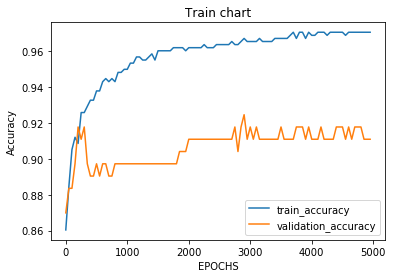

In [546]:
x = np.array(range(0,EPOCHS,Mark_point))
y1, y2 = np.array(train_accuracy), np.array(validation_accuracy)
 
plt.plot(x, y1,label='train_accuracy')
plt.plot(x, y2,label='validation_accuracy')
 
plt.title('Train chart')
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
 
plt.legend()
plt.show()

In [547]:
#test part
i = 10 #test data position(just an example)
my_data = X_train[i][np.newaxis,:]
logits = digit_label
softmax_logits = tf.nn.softmax(logits)

sess=tf.InteractiveSession()  
sess.run(tf.global_variables_initializer())
model_file=tf.train.latest_checkpoint('ckpt/')
saver.restore(sess,model_file)
predict = softmax_logits.eval(feed_dict={input_data: my_data})
print ("Predict data:",predict)
print ("True data:",y_train[i])

INFO:tensorflow:Restoring parameters from ckpt/model.ckpt
Predict data: [[  9.98369634e-01   1.89016643e-18   1.63038902e-03]]
True data: [ 1.  0.  0.]
